In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
import pandas as pd

from scipy.ndimage.filters import gaussian_filter1d
from matplotlib.patches import Polygon

# Import the project utils
import sys
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
from sequence_logo import *
mwc.set_plotting_style()


colors_qual=sns.color_palette(
    ['#55934d', '#b73720', '#4976b7', '#dda83d', '#985c9b', '#905426']) # Colors for non-sequential data
sns.set_palette(colors_qual)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Code for Figure 2

# Sequence logos

One way to display energy matrix data is to use sequence logos. These display a) the relative frequency of each base at each position and b) the amount of information contained at each position. 

To find the relative frequency of each base $b$ at a position $i$ in an energy weight matrix, we use the equation

\begin{equation}
\mathrm{prob}_{b,i} = \frac{e^{-\beta \varepsilon_{b,i}}}{e^{-\beta \varepsilon_{A,i}} + e^{-\beta \varepsilon_{C,i}} + e^{-\beta \varepsilon_{G, i}} + e^{-\beta \varepsilon_{T, i}}}.
\end{equation}

We then scale the frequencies at each position by the amount of information in bits at that position, where 2 bits is the maximum amount of information at a given position. The information $R$ is given by

\begin{equation}
R_i = 2 - H(i),
\end{equation}

where $H(i)$ is the Shannon entropy at position $i$, given by 

\begin{equation}
H(i) = - \sum_{b = A}^{T} f(b, i) \log_2{f(b,i)},
\end{equation}

where $b$ is the base identity (A, C, G, or T) and $f(b, i)$ is the frequency of a given base identity at position $i$. Here we will create sequence logos from each energy matrix as an additional point of comparison. 

The code for crafting sequence logos is included in the module "sequence_logos.py". We can now move on to make sequence logos for our data.

In [25]:
# Import matrices
O1_r1_raw = np.load('../../data/models/splits/lacO1_R62_rep1_ThermoforT.npy')
O1_r2_raw = np.load('../../data/models/splits/lacO1_rep2_forT.npy')
O1_1027_raw = np.load('../../data/models/splits/lacThermoforTO1.npy')
O2_1027_raw = np.load('../../data/models/splits/lacThermoforTO2.npy')
O3_1027_raw = np.load('../../data/models/splits/lacThermoforTO3.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
O2_1027_fixed = np.zeros(np.shape(O2_1027_raw))
O3_1027_fixed = np.zeros(np.shape(O3_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = sortseq.fix_wt(O1_1027_raw[i], 'AATTGTGAGCGGATAACAATT')
    O2_1027_fixed[i] = sortseq.fix_wt(O2_1027_raw[i], 'AAATGTGAGCGAGTAACAACC')
    O3_1027_fixed[i] = sortseq.fix_wt(O3_1027_raw[i], 'GGCAGTGAGCGCAACGCAATT')

In [80]:
# Define function for determining Pearson's corellation coefficient. 

def pearsons(X, Y):
    cov = 0
    for i in range(len(X)):
        cov += (X[i] - np.mean(X)) * (Y[i] - np.mean(Y))/len(X)
    return cov/(np.std(X) * np.std(Y))

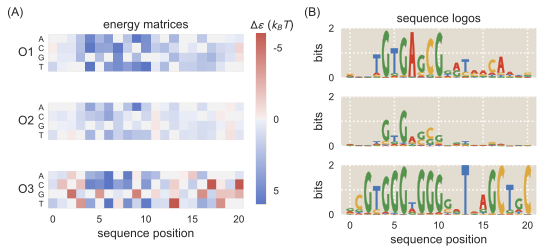

In [64]:
div_colors = sns.diverging_palette(16, 258, s=56, l=51, n=15, sep=2, center='light', as_cmap=True)
fig_ops = ['O1', 'O2', 'O3']
fig_mats = [np.mean(O1_1027_fixed, axis=0), 
            np.mean(O2_1027_fixed, axis=0), 
            np.mean(O3_1027_fixed, axis=0)]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(7.5, 3.5))

# Create dummy image for "flipped" colorbar

dummy_colors = sns.diverging_palette(258, 16, s=56, l=51, n=15, sep=2, center='light', as_cmap=True)
im = ax[0][0].imshow(fig_mats[0].T, cmap=dummy_colors, clim=[-6, 6])


# Plot energy matrices using a color map
for i, row in enumerate(ax):
    row[0].imshow(fig_mats[i].T, cmap=div_colors, clim=[-6, 6])
    row[0].yaxis.set_ticks([0, 1, 2, 3])
    row[0].set_yticklabels(['A', 'C', 'G', 'T'], ha='center', fontsize=8)
    row[0].set_xticklabels(['', '', '', '', ''])
    row[0].set_ylabel(fig_ops[i], rotation=0, va='center', ha='right')
    row[0].grid(False)

# Plot sequence logos associated with each energy matrix
    seq_logo(fig_mats[i], ax=row[1], colors=['#ce3e27', '#dda83d', '#55934d', '#4976b7'])
    row[1].set_xlim(0, 22)
    row[1].set_ylim(0, 2)
    row[1].set_yticks([0, 1, 2])
    row[1].set_ylabel('bits')
    row[1].set_yticklabels(['0', '', '2'])
    row[1].set_xticks([1, 6, 11, 16, 21])
    row[1].set_xticklabels(['', '', '', '', ''])

    
ax[2][0].set_xticklabels(['0', '0', '5', '10', '15', '20'])
ax[2][0].set_xlabel('sequence position')
ax[2][1].set_xticklabels(['0', '5', '10', '15', '20'])
ax[2][1].set_xlabel('sequence position')

ax[0][0].set_title('energy matrices', fontsize=12)
ax[0][1].set_title('sequence logos', fontsize=12)

plt.tight_layout(w_pad=7, h_pad=1)
plt.figtext(0.49, 0.9, r'$\Delta \varepsilon$ ($k_BT$)', ha='center', fontsize=12)
plt.figtext(0, 0.95, '(A)', fontsize=12)
plt.figtext(0.55, 0.95, '(B)', fontsize=12)

cb_ax = fig.add_axes([0.46, 0.2, 0.02, 0.68])
cb = fig.colorbar(im, cb_ax)
cb.set_ticks([-5, 0, 5])
cb.set_ticklabels([5, 0, -5])

plt.savefig('fig2_AB.pdf', bbox_inches='tight')

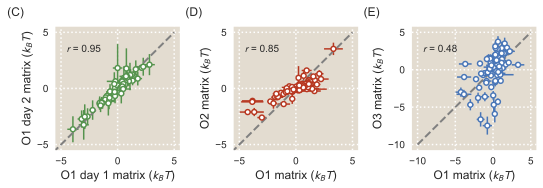

In [90]:
fig, ax = plt.subplots(ncols=3, figsize=(7.5, 2.5))

for a in ax:
    a.plot([-10, 5], [-10, 5], ls='--', color='gray')
ax[0].errorbar(np.ravel(np.mean(O1_r1_raw, axis=0)), np.ravel(np.mean(O1_r2_raw, axis=0)),\
              xerr = np.ravel(np.std(O1_r1_raw, axis=0)), yerr = np.ravel(np.std(O1_r2_raw, axis=0)),\
              marker='o', markersize=5, ls='', color='white', markeredgewidth=1.5, markeredgecolor=colors_qual[0],\
              ecolor=colors_qual[0], elinewidth=1.5)
ax[0].set_xlabel(r'O1 day 1 matrix ($k_BT$)')
ax[0].set_ylabel(r'O1 day 2 matrix ($k_BT$)')
ax[0].set_xlim(-5.5, 5.5)
ax[0].set_ylim(-5.5, 5.5)
ax[0].set_yticks([-5, 0, 5])

ax[1].errorbar(np.ravel(np.mean(O1_1027_raw, axis=0)), np.ravel(np.mean(O2_1027_raw, axis=0)),\
              xerr = np.ravel(np.std(O1_1027_raw, axis=0)), yerr = np.ravel(np.std(O2_1027_raw, axis=0)),\
              marker='o', markersize=5, ls='', color='white', markeredgewidth=1.5, markeredgecolor=colors_qual[1],\
              ecolor=colors_qual[1], elinewidth=1.5)
ax[1].set_xlabel(r'O1 matrix ($k_BT$)')
ax[1].set_ylabel(r'O2 matrix ($k_BT$)')
ax[1].set_xlim(-5.5, 5.5)
ax[1].set_ylim(-5.5, 5.5)
ax[1].set_yticks([-5, 0, 5])

ax[2].errorbar(np.ravel(np.mean(O1_1027_raw, axis=0)), np.ravel(np.mean(O3_1027_raw, axis=0)),\
              xerr = np.ravel(np.std(O1_1027_raw, axis=0)), yerr = np.ravel(np.std(O3_1027_raw, axis=0)),\
              marker='o', markersize=5, ls='', color='white', markeredgewidth=1.5, markeredgecolor=colors_qual[2],\
              ecolor=colors_qual[2], elinewidth=1.5)
ax[2].set_xlabel(r'O1 matrix ($k_BT$)')
ax[2].set_ylabel(r'O3 matrix ($k_BT$)')

plt.figtext(0, 1, '(C)', fontsize=12)
plt.figtext(0.33, 1, '(D)', fontsize=12)
plt.figtext(0.66, 1, '(E)', fontsize=12)

plt.figtext(0.11, 0.8, r'$r$ = %0.2f' % pearsons(np.mean(O1_r1_raw, axis=0).ravel(),\
                                                np.mean(O1_r2_raw, axis=0).ravel()))
plt.figtext(0.44, 0.8, r'$r$ = %0.2f' % pearsons(np.mean(O1_1027_raw, axis=0).ravel(),\
                                                np.mean(O2_1027_raw, axis=0).ravel()))
plt.figtext(0.77, 0.8, r'$r$ = %0.2f' % pearsons(np.mean(O1_1027_raw, axis=0).ravel(),\
                                                np.mean(O3_1027_raw, axis=0).ravel()))

plt.tight_layout()
plt.savefig('fig2_CDE.pdf', bbox_inches='tight')